# Evaluating Model Performance

In this demo, we'll be using the Red Wine Quality dataset. The datset can be used in both regression and classification models. The purpose of this notebook is to build different models, classifiers and regressors, and compare their performance to see which one performs the best on our data.

### Import Packages

Let us import dffml and other packages that we might need.

In [1]:
from dffml import *
import asyncio
import nest_asyncio

To use asyncio in a notebook, we need to use nest_asycio.apply()

In [2]:
nest_asyncio.apply()

### Build our Dataset

Dffml has a very convinient function `cached_download()` that can be used to download datasets and make sure you don't download them if you have already.

In [3]:
data_path = await cached_download(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv",
    "wine_quality.csv",
    "789e98688f9ff18d4bae35afb71b006116ec9c529c1b21563fdaf5e785aea8b3937a55a4919c91ca2b0acb671300072c",
)

In Dffml, we try to use asynchronicity where we can, to get that extra bit of performance. Let's use the async version of load() to load the dataset that we just downloaded into a source. We can easily achieve this by declaring a CSVSource with the data_path and the delimiter since the data we downloaded seems to have a non-comma delimiter.

After that, we can just create an array of records by loading each one through the load() function.

Feel free to also try out the no async version of load().


In [4]:
async def load_dataset(data_path):
    data_source = CSVSource(filename=data_path, delimiter=";")
    data = [record async for record in load(data_source)]
    return data


data = asyncio.run(load_dataset(data_path))

Dffml lets you visualize a record in quite a neat fashion. Lets have a look.

In [5]:
print(data[0], "\n")
print(len(data))


	Key:	0
                      Record Features
+------------------------------------------------------------+
| fixed acidity |                    7.4                     |
+------------------------------------------------------------+
|volatile acidit|                    0.7                     |
+------------------------------------------------------------+
|  citric acid  |                     0                      |
+------------------------------------------------------------+
| residual sugar|                    1.9                     |
+------------------------------------------------------------+
|   chlorides   |                   0.076                    |
+------------------------------------------------------------+
|free sulfur dio|                     11                     |
+------------------------------------------------------------+
|total sulfur di|                     34                     |
+------------------------------------------------------------+
|    den

Lets split our dataset into train and test splits.

In [6]:
train_data = data[320:]
test_data = data[:320]
print(len(data), len(train_data), len(test_data))

1599 1279 320


### Instantiate our Models with parameters
Dffml makes it quite easy to load multiple models dynamically using the `Model.load()` function. After that, you just have to parameterize the loaded models and they are ready to train interchangably!

For this example, we'll be demonstrating 2 basic models for classification and 2 for regression.

In [ ]:
XGBCModel = Model.load("xgbclassifier")
ScikitETCModel = Model.load("scikitetc")
XGBRModel = Model.load("xgbregressor")
ScikitLRModel = Model.load("scikitlr")

features = Features(
    Feature("fixed acidity", int, 1),
    Feature("volatile acidity", int, 1),
    Feature("citric acid", int, 1),
    Feature("residual sugar", int, 1),
    Feature("chlorides", int, 1),
    Feature("free sulfur dioxide", int, 1),
    Feature("total sulfur dioxide", int, 1),
    Feature("density", int, 1),
    Feature("pH", int, 1),
    Feature("sulphates", int, 1),
    Feature("alcohol", int, 1),
)

model1 = XGBCModel(
    features=features, predict=Feature("quality", int, 1), location="xgbc",
)
model2 = ScikitETCModel(
    features=features, predict=Feature("quality", int, 1), location="scikitetc",
)
model3 = XGBRModel(
    features=features, predict=Feature("quality", int, 1), location="xgbr",
)
model4 = ScikitLRModel(
    features=features, predict=Feature("quality", int, 1), location="scikitlr",
)

### Train our Models
Finally, our models are ready to be trained using the `high-level` API. Let's make sure to pass each record as a parameter by simply using the unpacking operator(*).

In [ ]:
await train(model1, *train_data)
await train(model2, *train_data)
await train(model3, *train_data)
await train(model4, *train_data)

### Test our Models
To test our model, we'll use the `accuracy()` function in the `high-level` API.

In [9]:
Accuracy = await accuracy(model1, *test_data)
print("Accuracy1:", Accuracy)

Accuracy2 = await accuracy(model2, *test_data)
print("Accuracy2:", Accuracy2)

Accuracy3 = await accuracy(model3, *test_data)
print("Accuracy3:", Accuracy3)

Accuracy4 = await accuracy(model4, *test_data)
print("Accuracy4:", Accuracy4)

Accuracy = [Accuracy, Accuracy2, Accuracy3, Accuracy4]

Accuracy1: 0.575
Accuracy2: 0.5875
Accuracy3: 0.1362514931483253
Accuracy4: 0.1320087097514161


<BarContainer object of 4 artists>

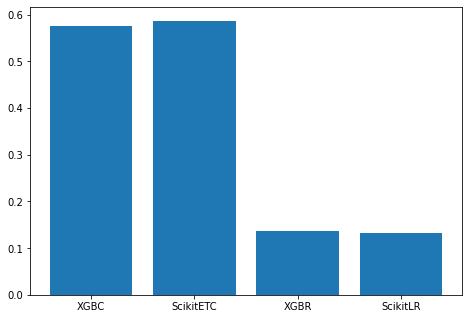

In [10]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.bar(["XGBC", "ScikitETC", "XGBR", "ScikitLR"], Accuracy)

From the accuracies and the above plot, it is quite obvious that the classifiers we built perform better on the Red wine quality dataset than our regressors. 